* Tun-Chieh Hsu
* Net ID: th199
* Setup - All functions were defined in following two chunks, the report starts from P.7

In [1]:
# Import Library
import numpy as np
import scipy
import operator
import scipy.stats
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.dates as dates
import pandas as pd
import sys
import pickle
from scipy.cluster.hierarchy import cophenet
from scipy.spatial.distance import pdist
from scipy.special import gammaln, psi
from datetime import datetime
from numpy import transpose as t
from numpy.linalg import eigvals, eig, det, inv
from scipy.special import gammaln
from scipy.cluster.hierarchy import dendrogram, linkage
from numpy import matmul, transpose, matrix, multiply, divide,sqrt,diag,log,pi
%matplotlib inline  


In [108]:
# Function setup

# Log Likelihood
def ltpdf(x,m,w,n,D):
    q = x.shape[0]
    C = transpose(np.linalg.cholesky(D));
    e = inv(C)@(x-m);
    d = n+q-1;
    ltpdf = q*np.log(2)/2 - q*np.log(2*pi*w)/2 - sum(np.log(diag(C))
                                                    ) - (d+1)*np.log(
        1+(transpose(e)@e)/w)/2;
    ltpdf += sum(gammaln(1 + d - np.array(list(range(0,q))))/2
                ) - sum(gammaln(d - np.array(list(range(0,q))))/2)
    return(ltpdf)

## Multivariate DLM
## only for local level , thus p = 1
class multi_filtering(object):
    
    def __init__(self, Y  ,m0 = matrix(np.ones([1,20])),
                 c0 = 0.01 , n0 = 3 ,beta = 0.9, delta = 0.9, 
                 backwardSmooth = False, Print = True):
        
        ## tune beta
        q = 20

        
        #change discounts to assess, compare marginal likelihood
        p=1;   
        F=np.matrix(np.ones([1,T]));

        #delta = 0.9; # discount level
        #beta = 0.9;  # discount volatility

        n0 = n0 ; 
        h0=n0+q-1; 
        D0=np.matrix(h0*np.identity(q));

        z = np.ones([p,q],dtype=complex);  
        zq=np.zeros([q,1],dtype=complex); 

        M0 = m0; 
        r=0.99; # priors
        Mt = M0;

        C0= np.matrix( c0 *np.identity(p))
        Ct=C0;        # initial Theta prior 

        n = n0; 
        h=h0;
        D = D0; 
        St=D/h;         # initial Sigma prior


        sMt = np.ones([p,q,T],dtype=complex); 
        sCt=np.zeros([p,p,T],dtype=complex);
        sdCt=np.zeros([p,q,T],dtype=complex);
        sSt=np.zeros([q,q,T],dtype=complex);  
        snt=np.zeros(T,dtype=complex);
        sloglik=np.zeros(T,dtype=complex); 

        sEt = matrix(np.zeros([q,T],dtype=complex))

        eigs = np.zeros([q,T],dtype=complex)
        eig_vec = []
        eig_sort_index = []
        
        self.M0 = M0
        self.C0 = C0
        self.S0 = St
        self.delta = delta
        self.beta = beta
        
        if Print:
            print('Start forward filtering...')
        
        # # forward filtering: 
        for t in range(T):
            ft = np.matrix(transpose(Mt) @ F[:,t])
            et = Y[:,t] - ft;
            Rt = Ct/delta; 
            h  = beta*h; 
            n=h-q+1; 
            D = beta*D;  
            snt[t]=n;  
            qvt = 1 + transpose(F[:,t])@Rt@F[:,t]; 
            sEt[:,t] = transpose(np.squeeze(et)/np.sqrt(qvt*np.diag(St)))

            At = Rt@F[:,t]/qvt;
            h += 1; 
            n += 1; 
            D += et @ transpose(et)/qvt
            St=D/h; 
            St=(St+transpose(St))/2; 
            Mt = Mt + At@transpose(et);
            Ct = Rt - At@np.transpose(At)*qvt;

            #
            sloglik[t] = ltpdf(et,zq,qvt,n,D);    

            # PCA
            if backwardSmooth == False:
                           
                eig_vals, eig_vecs = eig(St)
                eig_vals_sorted = np.sort(eig_vals)[::-1]
                eig_vecs_sorted = eig_vecs[:, eig_vals.argsort()[::-1]]
                eigs[:,t] = eig_vals_sorted
                eig_sort_index.append(eig_vals.argsort()[::-1])

                if (t>0):
                    a = eig_vecs_sorted - eig_vec[t-1]; 
                    f = -eig_vecs_sorted - eig_vec[t-1];
                    eig_a = np.sum(np.multiply(a,a),axis = 0)
                    eig_f = np.sum(np.multiply(f,f),axis = 0)

                    compare = np.argmin([eig_a,eig_f],0)
                    temp_compare = np.array(compare[0])
                    index = list(np.where(temp_compare == 1)[0])
                    eig_vecs_sorted[:,index] = -1 * eig_vecs_sorted[:,index]

                eig_vec.append(eig_vecs_sorted)
            
            # save
            sCt[:,:,t]=Ct;
            sSt[:,:,t]=St; 
            sMt[:,:,t] = Mt; 
            sdCt[:,:,t] = sqrt(transpose(diag(Ct)*diag(St)));
        
        
        if Print:
            print('Start Backward Smoothing...')
                
        if backwardSmooth:
            # reverse smoothing 
            K=inv(sSt[:,:,-1]); 
            n=snt[:-1]; 
            Mt = sMt[:,:,-1]; 
            Ct = sCt[:,:,-1]; 

            for t in list(range(1,T-1))[::-1]:
                K=(1-beta)*inv(sSt[:,:,t])+beta*K;         
                St = inv(K); 
                sSt[:,:,t]=St;  
                Mt = (1-delta)*sMt[:,:,t] + delta*Mt;  
                sMt[:,:,t] = Mt; 
                Ct = (1-delta)*sCt[:,:,t] + np.power(delta,2)*Ct;    
                sCt[:,:,t] = Ct; 
                sdCt[:,:,t] = sqrt(diag(Ct)* transpose(diag(St)));
            
        #print(eig_a)
        #print(eig_f)
        #print(np.argmin([eig_a,eig_f],0))

        self.sCt = sCt
        self.sSt = sSt
        self.sMt = sMt
        self.sdCt = sdCt
        self.eigs = eigs
        self.sloglik = sloglik
        self.eig_vec = eig_vec
        self.eig_sort_index = eig_sort_index
        
        if Print:
            print('Finished...')
    


## heatmap for eigenvectors
def cluster_heatmap(model,component,top):
    eigvec_1 = np.array(model.eig_vec)   

    eigvec_1 = transpose(eigvec_1[:,:,component-1]).real
    
    eigvec_1 = eigvec_1[:top,:]
    
    ## Date label
    Date2 = Date.copy()
    for i in range(T):
        if i%5 != 0:
            Date2[i] = ''


    fig, ax = plt.subplots(figsize=(15,10))

    my_yticks = list(multi_data.columns)[:top][::-1]
    ax = sns.heatmap((eigvec_1[:top,:])**1,cmap="RdBu_r")
    ax.set_yticks(range((top)))
    ax.set_yticklabels(my_yticks,rotation = 0)

    #ax.set_xticks(range(T))
    ax.set_xticklabels(Date2,rotation = 90)

    #ax.xticks(range(T), Date, rotation= 45);
    ax.tick_params(labelsize=15,axis='y')
    ax.tick_params(labelsize=15,axis='x')
    ax.set_title('Component ' + str(component),fontsize= 20)
    #plt.title('add title here')
    for label in ax.xaxis.get_ticklabels()[::2]:
        label.set_visible(False)
    plt.show()

## PC projection
def project_component(Y,eigs_vec,n):
    component = np.zeros([len(eigs_vec),n])
    for i in range(len(eigs_vec)):
        component[i,:] = np.abs(transpose(Y[:,i]) @ eigs_vec[i][:,0:n])
    return(component)

 
    
## KL divergence
def KLdivNIWDLM( q, r, e, F, H, R, s, B, A, w):

    # KL change assessment measure in MVDLM - efficient computation 
    # q = series dimension
    # r = regression vector dimension
    # e = q-vector 1-step point forecast error
    # F = r-vector regression 
    # prior for pxq state matrix and qxq var matrix is NIW(H,R,s,B)
    # A = computed adapative vector A=RF/q 
    # w = 1+F'RF
    #
    #Kniw = np.ones(2)#  first is expected KL on Theta, second is KL on Sigma
    #
    Ir = np.mat(np.eye(r)); 
    Iq = np.eye(q);  
    Ri=inv(R);
    Bi=inv(B); 
    ldetB=log(det(B));  
    #
    g=s+q-1; n=s+1; d=n+q-1; # dofs 

    # KL for Theta: 
    k = transpose(A) @ (Ir + w * F @ transpose(A)) @ F/w
    c = transpose(e)*Bi*e; 
    ldetCbyR = -log(det(Ir+w*A*transpose(A)));
    trRCiminusr = w*transpose(A)*F; 
    ldetD = ldetB+log(1+c/w);
    trBiDminusq = c/w;  
    trquadform = k*c; 
    Kt = (q*ldetCbyR + trRCiminusr + g*trquadform)/2;  # expected Theta KL 
        
    # KL for Sigma: 
    logcqsbycqn =  q*log(2)/2 - sum(gammaln(
        (g - np.array(range(q)))/2)) + sum(gammaln(
        (d - np.array(range(q)))/2));
    eldetsigma  =  ldetB - q*log(2)  - sum(psi((s + np.array(range(q)))/2)); 
    Ks = logcqsbycqn +g*ldetB/2 - d*ldetD/2 + eldetsigma/2 + g*trBiDminusq/2; 
    # expected Sigma KL 
    
    return(np.array([Kt[0,0],Ks[0,0]]))


## scatter plot for eigenvector
def scatter(model,ii,j):

    # The scatter plot of eigenvector
    a = model.eig_vec
    c2 = [i[0] for i in a[20][:,ii-1].real.tolist()]
    c3 = [i[0] for i in a[20][:,j-1].real.tolist()]

    fig, ax = plt.subplots(figsize=(10,10))
    ax.scatter(c2, c3)
    n = list(multi_data.columns)[:20]
    for i, txt in enumerate(n):
        ax.text(c2[i],c3[i],txt, size = 12)
    ax.axhline(linewidth=1, color='b', linestyle  = 'dashdot');
    ax.axvline(linewidth=1, color='b', linestyle  = 'dashdot');
    ax.set_xlabel('Component ' + str(ii),fontsize = 15);
    ax.set_ylabel('Component ' + str(j),fontsize = 15);
    ax.set_title('Component ' + str(ii) + ' and ' 'Component ' + str(j),
                 fontsize = 20);


#  Introduction

The data I would like to explore in the project is Google Trend data. The Google Trend collects search volume over time and allows us to measure interest in a particular topic. In this case, we are particularly interested in the topics regarding business, market and economy. Thus, we select the terms from Harvard IV-4 Dictionary and the Lasswell Value Dictionary, which classified vocabularies into different categories. We focus on the terms from the business and economy categories. 

After selecting the terms of interest, we downloaded the daily search volume of these terms from 01/01/2017 to 09/01/2017 through Google Trend API. In addition, we also downloaded the terms that was extended by these words. For example, when downloading the search volume of health care, we may also want to consider the term `Obama health care', and 'Obama care'. In this case, we set the criteria to be 10 and selected the top 10 relating queries. In total, there are 150 time series. Noticed that the resulting numbers in each series is scaled on a range of 0 to 100 based on a topic’s proportion to all searches on all topics.   

One topic that we are interested in is the correlation structure between the searched terms. Is there any common pattern or trend between the terms? Thus, we will consider dynamic factor analysis to explore the correlation structure. Under the setting of dynamic linear model, we could update the covariance matrix $\mathbf{\Sigma_t}$ and apply principle component analysis $\mathbf{\Sigma_t = E_t \Delta_t E_t^{'}}$ for each time $t = 1,...,T$. The result serves as a reference of the correlation structure and dynamic clustering overtime . In addition, eigenvalues matrix $\Delta_t$ in each step $t$ could be considered as the change of variance explained proportion over time.

After the analysis of dynamic factor analysis, we are interested in using the Kullback–Leibler (KL) divergence of covariance matrix in each $t$, that is, measure the KL divergence between $p(\mathbf{\Sigma_t}|D_t)$ and $p(\mathbf{\Sigma_t}|D_{t-1})$, where $D_{t-1} = \{x_1,...,x_{t-1}\}$. We are interested in building our own market index with google trend data. Thus, we use the KL divergence to monitor the volatility of KL divergence, and compare it with VIX index, which was considered as one popular measure of the stock market's expectation of volatility implied by S&P 500 index options. 

In the following section, we will first present exploratory data analysis, following with the methodology introduction and analysis result. Finally, a discussion section will be presented. 

#  Exploratory Data Analysis


In [101]:
from problem import get_train_data
from sklearn.preprocessing import StandardScaler
import numpy as np

data_train, labels_train = get_train_data()
data_train = data_train.drop(columns=['Range F 14'])
data_train = data_train + 185
scaler = StandardScaler()
scaled_data = scaler.fit_transform(data_train)

#data_train = data_train + 9047
data = pd.DataFrame(scaled_data.copy(), index =data_train.index, columns = data_train.columns) 
vix_close = labels_train.copy()

/Users/ramzimissaoui/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/data.py:625: DataConversionWarning: Data with input dtype float32, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/Users/ramzimissaoui/anaconda3/lib/python3.6/site-packages/sklearn/base.py:462: DataConversionWarning: Data with input dtype float32, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)


After deleting some unrelated topics, the data of our interest records 148 search volumes and VIX index starting from 01/03/2017 to 09/05/2017 (170 days in total). The figure below shows the search volumes of some selected terms. From the figure, we found the series have great volatility over time. As a result, we took log transformation on each series.


In [99]:
# dimension of data
#data.iloc[:,2:].shape
min([min(data.iloc[:,i].values) for i in range(1,len(data.columns))])


0.5936345535623957

* Figure 1: The search volume of selected topics over time 


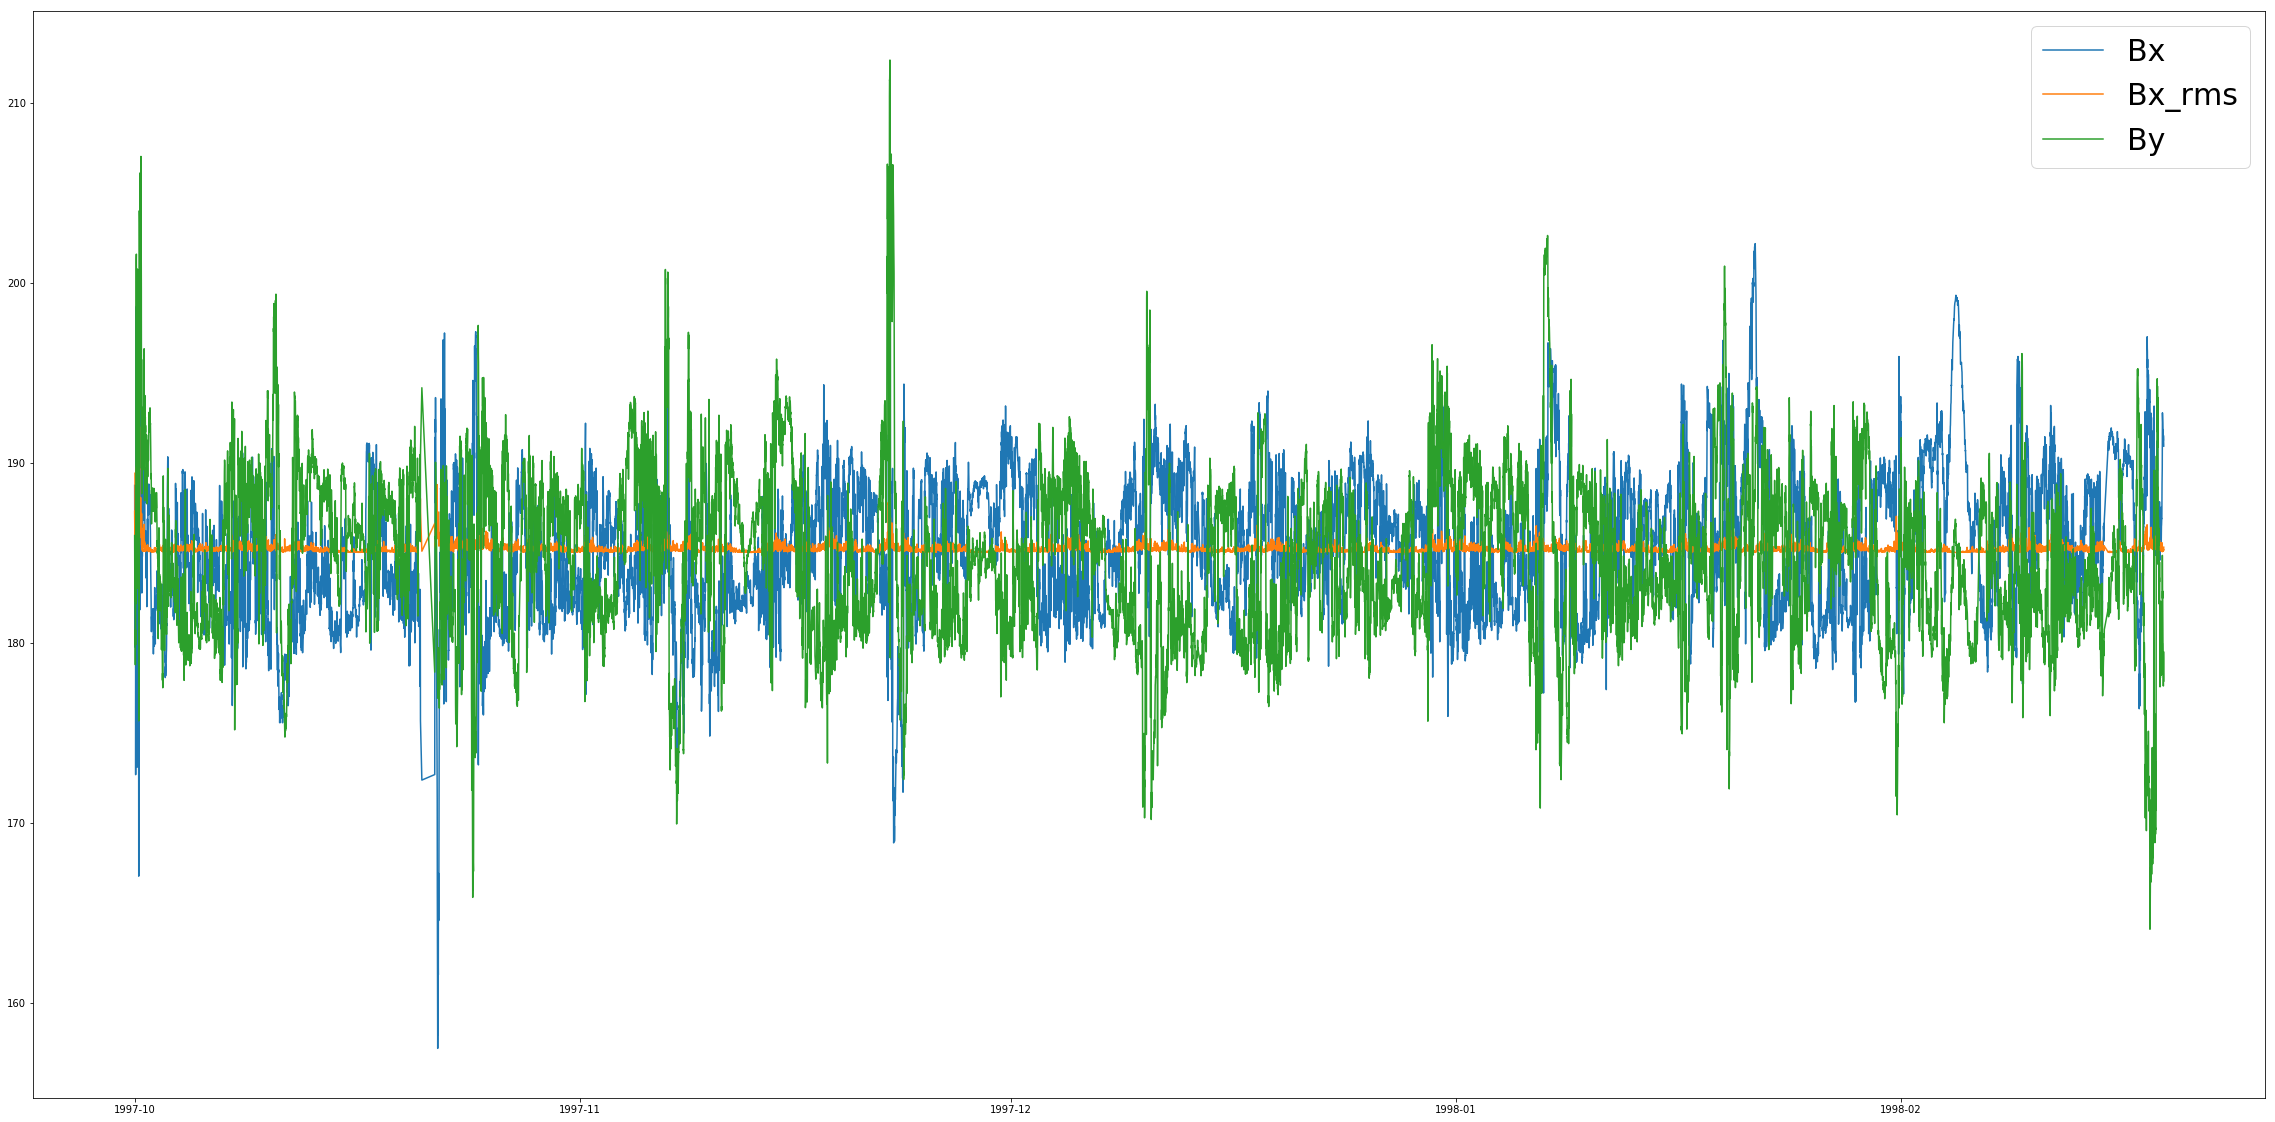

In [102]:
plt.figure(figsize=(40,20))
for i in range(1,4):
    plt.plot(data_train.iloc[:20000,i],label=list(data_train.columns)[i]);
plt.legend(fontsize = 30);

One of the goal is to explore the potential market volatility indicator. thus, we use Pearson's correlation as an exploratory tool to explore the correlation between VIX and vocabulary search volume. The list below shows the top 10 correlated terms with VIX index. According to the result, we found the topic 'bankruptcy' and 'gold stock' have the strongest correlation with the VIX index. The figure below shows the transformed series of some selected terms.


In [49]:
# log transformation
Y = np.mat(data.iloc[:,:])
Y[Y ==0 ] = 1
Y = np.log(Y)

#Y = Y - np.mean(Y,0)


/Users/ramzimissaoui/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:4: RuntimeWarning: invalid value encountered in log
  after removing the cwd from sys.path.


In [103]:
## Compute Pearson Correlation
data2 = data.copy()
#data2.iloc[:,:] = Y
## Compute Pearson Correlation
correlation = {}
for i in range(0,data2.shape[1]):
    x = data2.iloc[:,i]
    correlation.update({data.columns[i]: 
                        np.abs(scipy.stats.pearsonr(x, vix_close)[0])})
top_50_dict = sorted(correlation.items(),
                     key=operator.itemgetter(1),reverse=True)[:20]
top_10_dict = sorted(correlation.items(),
                     key=operator.itemgetter(1),reverse=True)[:10]
## Show Top 10
top_50_dict

[('RmsBob', 0.2164516156671335),
 ('Vth', 0.19710952427699602),
 ('B', 0.1479320864355846),
 ('Bz_rms', 0.09921206385227993),
 ('Range F 9', 0.0958546388555059),
 ('By_rms', 0.09485157395209617),
 ('Range F 7', 0.09290679278361212),
 ('Range F 11', 0.09112936359129425),
 ('Bx_rms', 0.09055786243405542),
 ('Range F 12', 0.07035320674722464),
 ('Range F 5', 0.05933378942194111),
 ('Range F 4', 0.055472278912707215),
 ('Range F 6', 0.05431051415903637),
 ('Range F 10', 0.03363426619416679),
 ('Range F 13', 0.029522414382376246),
 ('Range F 2', 0.026191756528353993),
 ('Na_nl', 0.02365784402007697),
 ('Range F 3', 0.019515773856043018),
 ('By', 0.01693088665342714),
 ('Bx', 0.014569364414202167)]

In [104]:
#selected top 50 series
multi_data = data2[[i[0] for i in top_50_dict]]
multi_data.head()
Y = np.mat(multi_data)
T,q = Y.shape
Y = transpose(Y)

* Figure 2: The log search volume of selected topics over time


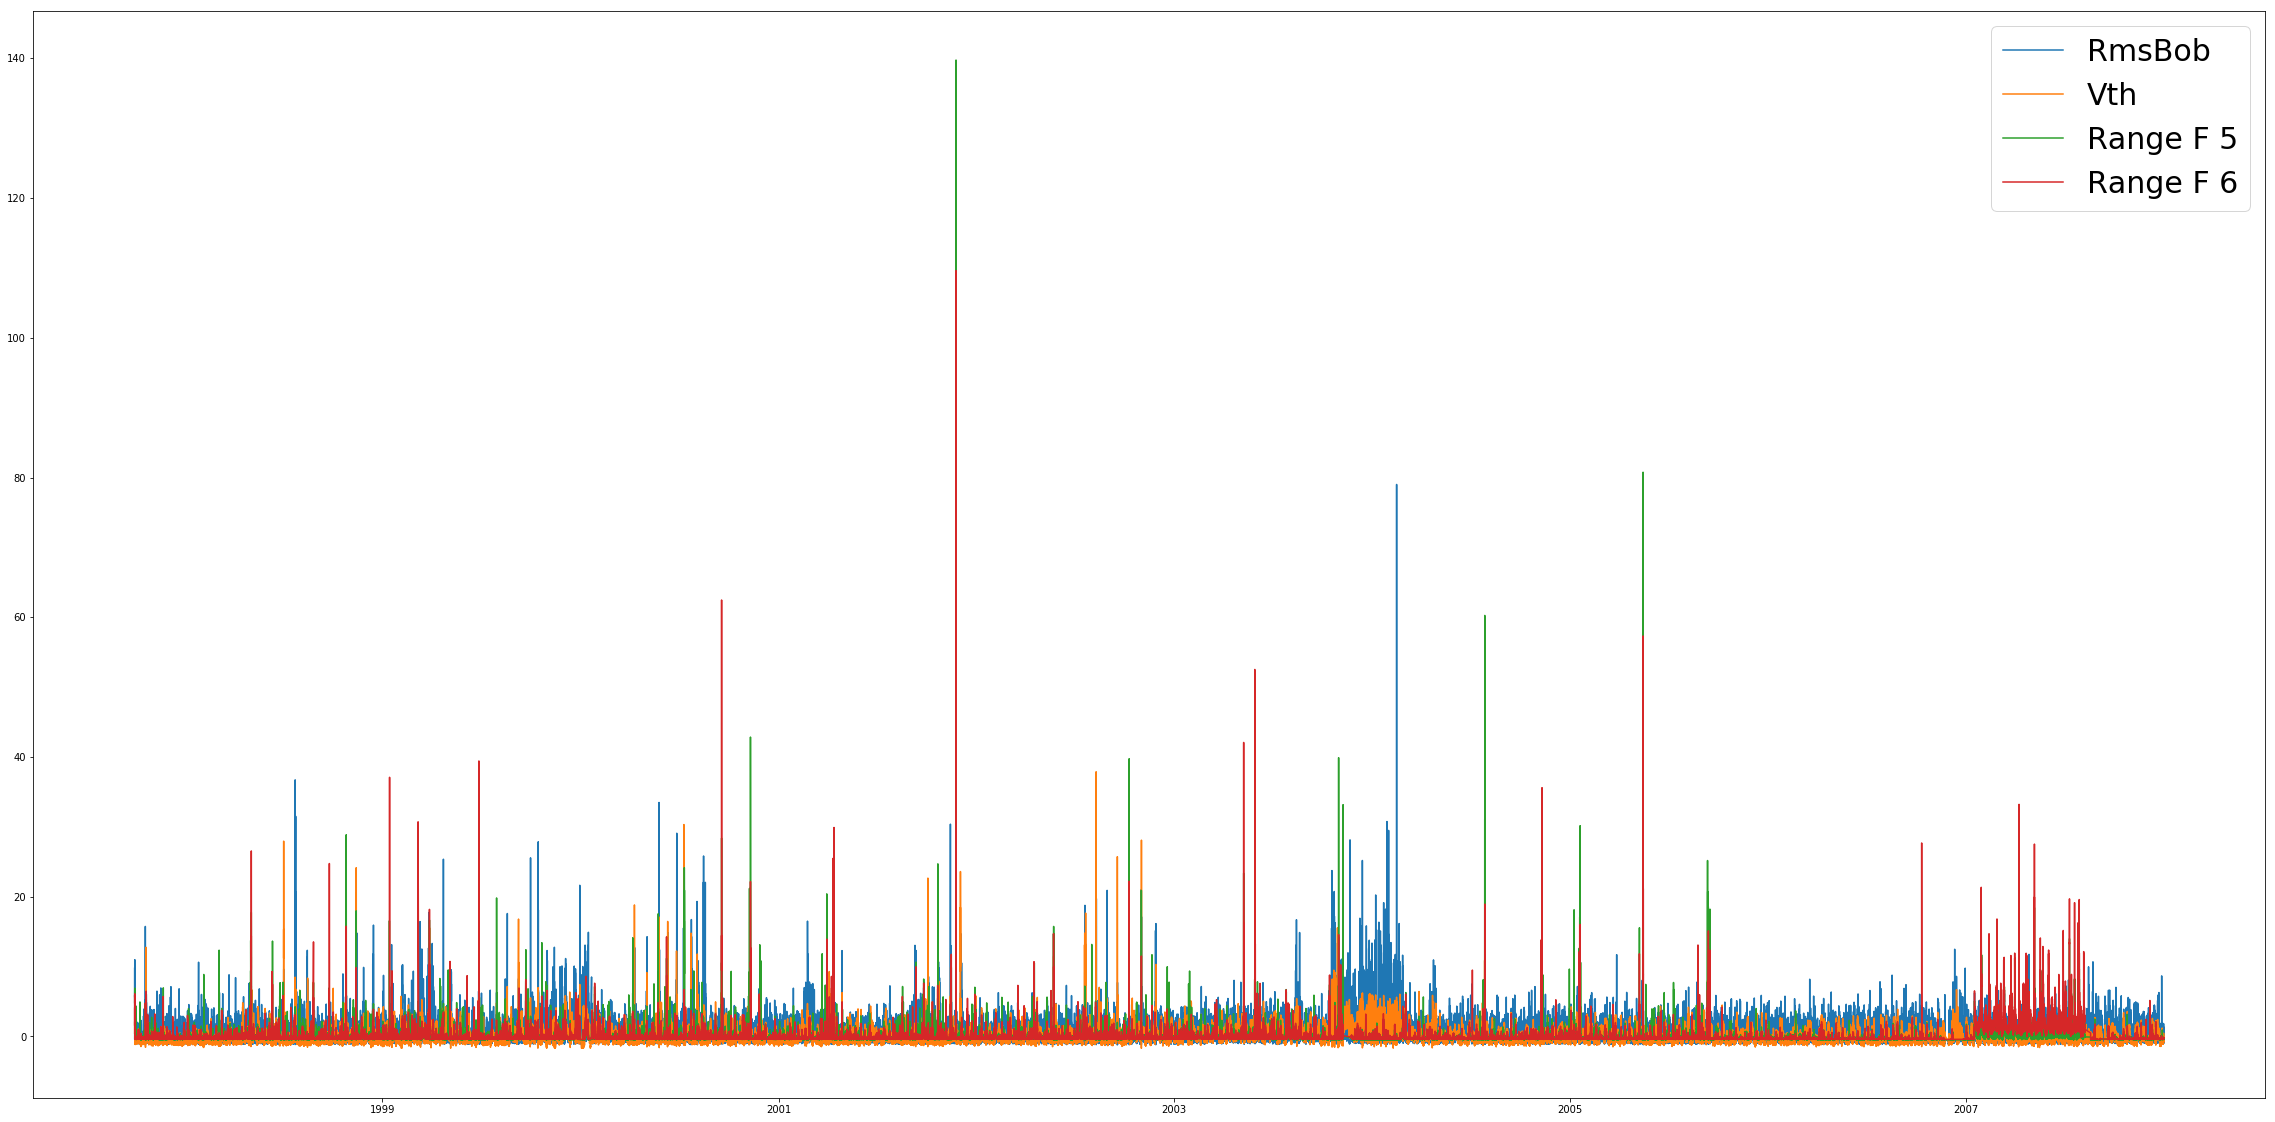

In [105]:
plt.figure(figsize=(40,20))
for i in [0,1,10,12]:
    plt.plot(multi_data.iloc[:,i],label=list(multi_data.columns)[i]);
plt.legend(fontsize = 30);


Since we can observe the cluster pattern with dynamic principal component analysis, we would like to use hierarchical clustering to explore the cluster structure first. According to the dendrogram, we could find that the topic with common terms tend to be clustered in same group, for example, 'debt' and 'us debt', 'apple stock and gold stock'.


* Figure 3: The Hierarchical Clustering Dendrogram

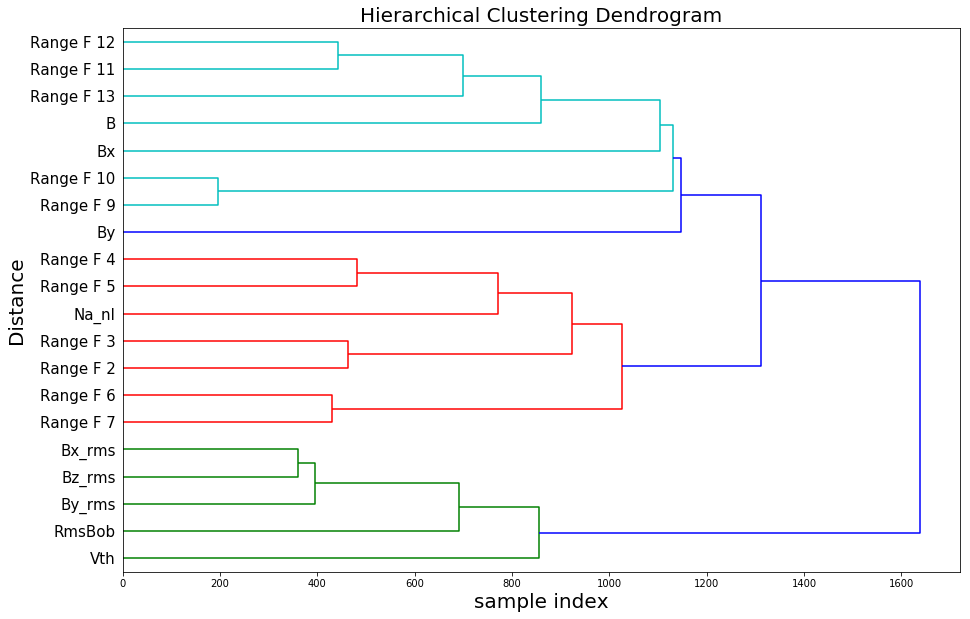

In [106]:
# Hierachical Clustering 
Z = linkage(Y, 'ward')
c, coph_dists = cophenet(Z, pdist(Y,'correlation'))
plt.figure(figsize=(15, 10))
plt.title('Hierarchical Clustering Dendrogram',fontsize = 20)
plt.xlabel('sample index',fontsize = 20)
plt.ylabel('Distance',fontsize = 20)
dendrogram(
    Z,
    labels = list(multi_data.columns),
    leaf_rotation=0.,  # rotates the x axis labels
    leaf_font_size=15,  # font size for the x axis labels
    orientation="right")
plt.show()

The Pearson's Correlation and Hierarchical Clustering serve as two good nonparametric tools to explore the data. 
In the following section, we will introduce multivariate dynamic linear model and dynamic principal component analysis.


# Dynamic Principal Component Analysis (DPCA)


Principle component analysis is a popular method for dimension reduction and data processing. PCA enjoy several advantages, one main advantage is that, it reduces the dimensionality of a data, while preserving as much variability as possible. Another advantage is that, we could discuss one principal component without considering others, due to principal components are uncorrelated to each other. In addition, we can observe the associations between the principle components and the original variables from the entries of eigenvectors. This result will serve as a good reference of clustering. 

Thus, PCA is an idea method for this dataset. First, we can use PCA to explore the cluster structure between topics over time, then reduce the number of series from nearly 150 to 10 by projecting the original series into new coordinate system. 

In order to apply PCA over time, we have to sequentially update the covariance matrix. Thus, we have to construct a multivariate dynamic linear model. In this analysis, we use the simplest multivariate model for the series. Thus, we are able to track the low levels of stochastic changes over time, under the context of dominant variation. The model was shown below: 

$$\begin{aligned}
\boldsymbol{y_t} &= \boldsymbol{\theta_t + \nu_t}, \;\;\;\; \boldsymbol{\nu_t} \sim N(\boldsymbol{0,\Sigma_t)} \\
\boldsymbol{\theta_t} &= \boldsymbol{\theta_{t-1} + \omega_t,\;\;\;\; \omega_t} \sim N(\boldsymbol{0},\omega_t \boldsymbol{\Sigma_t})\\
\end{aligned}$$

The distributions for the covariance matrices in the forward filtering are multivariate normal, inverse Wishart. The details of sequential updating, discount factor and prior selection could be found in Prado and West(2010). In this section, we will focus on the time-varying principal components analysis.<br /> 


We compute principal components of each of the $\Sigma_t$ from the sequential updating. The Principal component decomposition of each $\Sigma_t$ could be shown as: 
$$\boldsymbol{\Sigma_t} = \boldsymbol{E_t \Delta_t E_t^{'}} = \sum_{j = 1}^{q}\delta^{2}_{t,j}e_{t,j}e^{'}_{t,j}$$
where $\boldsymbol{\Delta}$ is diagonal matrix with nonnegative element $\delta_{t,1}^{2},...,\delta_{t,q}^{2}$ and in descending order, and where $\boldsymbol{E_t}$ is orthogonal with vectors columns $e_{t,j}$ for $j = 1,...,q$. <br /> 



In [109]:
## forward filtering Multivariate DLM
model = multi_filtering(Y = Y , m0 = matrix(np.ones([1,q])),
                        beta = 0.99, delta = 0.99, 
                            backwardSmooth = False,Print = False)

In [110]:
# construct variance proportion explained
sSt = model.sSt
sdCt = model.sdCt
sMt = model.sMt
sloglik = model.sloglik
eigs = model.eigs
eigs_vec = model.eig_vec
eigs_frac = 100*eigs/np.sum(eigs,axis = 0)



The $\delta_{t,j}$ is the underlying volatility that impact on the overall volatility. Thus, we transferred $\delta_{t,j}$ into $100\delta^{2}_{t,j}\mathbf{1^{'}\Delta 1}$, which could be considered as the proportion of variance explained over time. Figure 4 and Figure 5 shows the cumulative variance explained by components. From these figures, we found that component 1 is able to explain most of the volatility variation, although decreasing overtime. Around April, it could explain nearly $75\%$ of the variation. From another figure, we found the proportion of variation explained by other components increase overtime, especially for component 2. We might want to take a deeper look on the corresponding $\mathbf{E_t}$.<br />



* Figure 4: Cumulative Variance Explained by Components (Component 1 ~ 10)


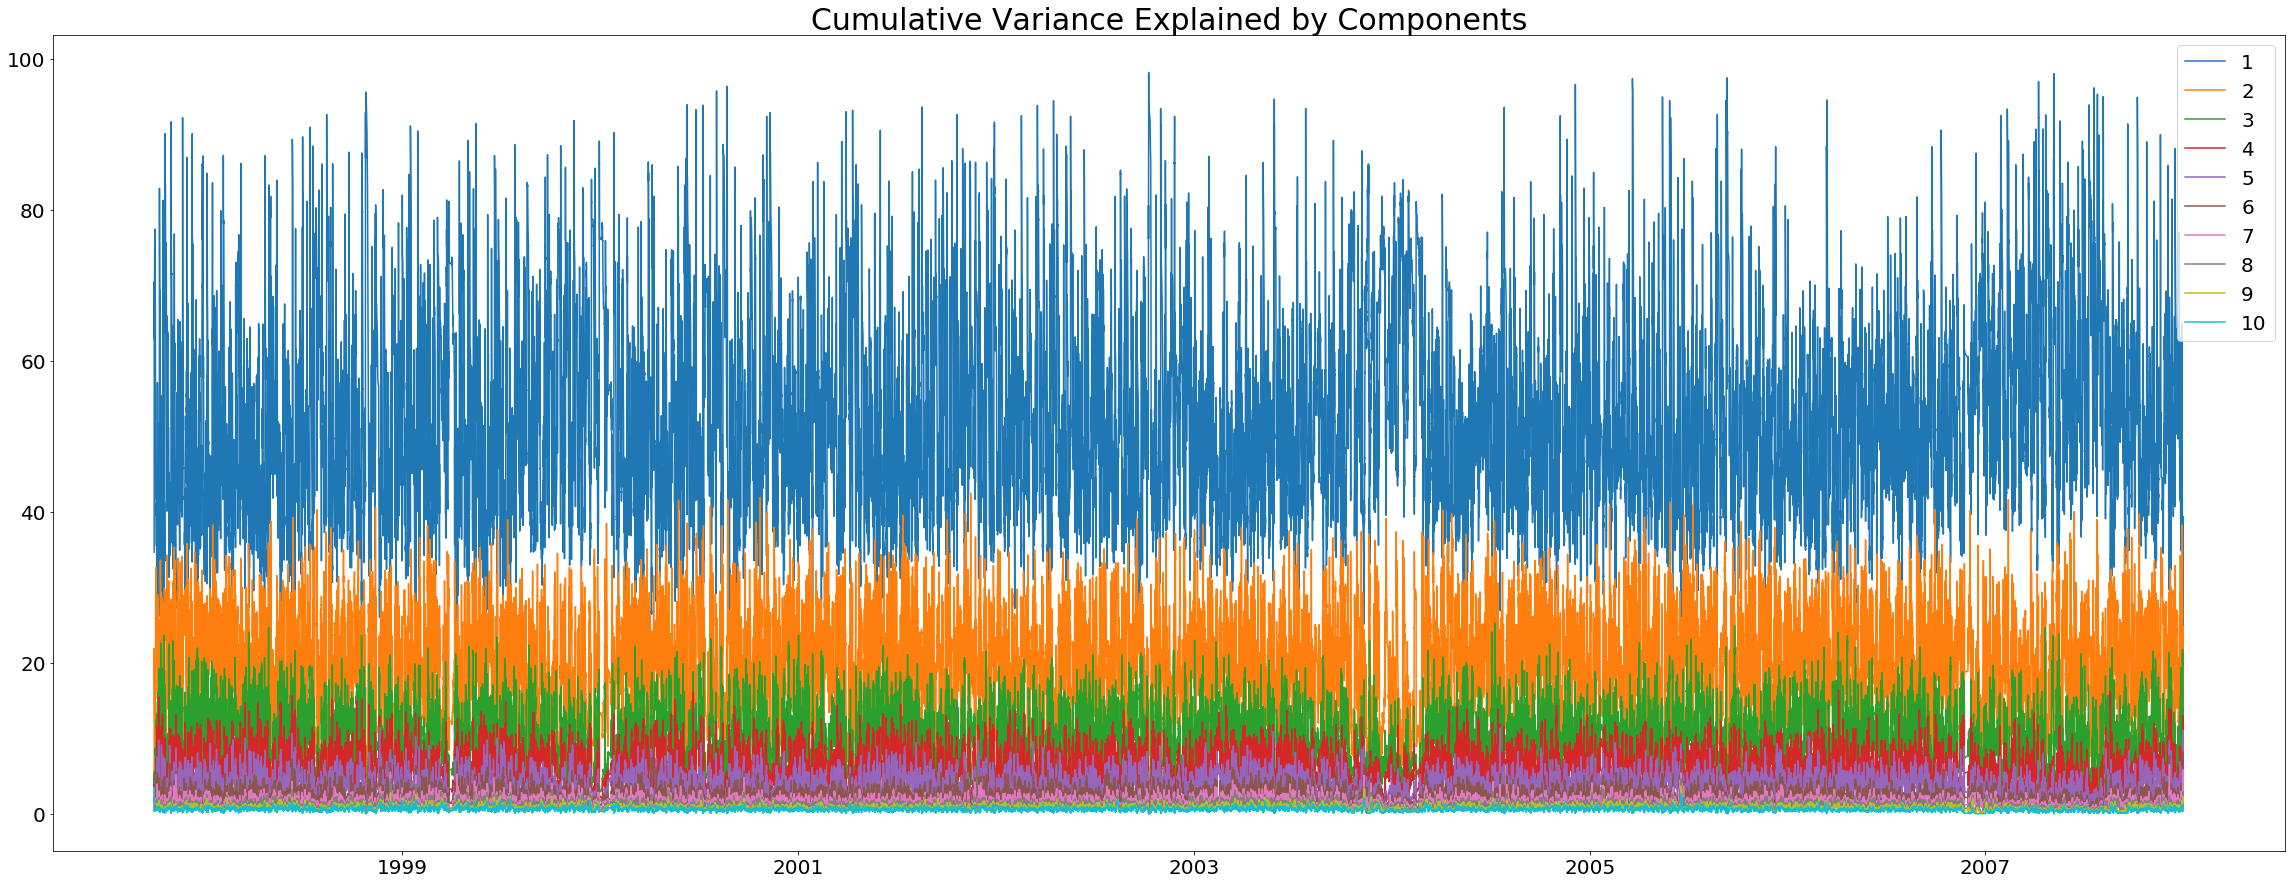

In [112]:
plt.figure(figsize=(40,15))
for i in range(0,10):
    plt.plot(data_train.index,eigs_frac[i,:].real,label = i+1)
    plt.tick_params(labelsize=20)
    plt.title('Cumulative Variance Explained by Components', fontsize = 30)
    plt.legend(fontsize = 20)

* Figure 5: Cumulative Variance Explained by Components (Component 2 ~ 10)

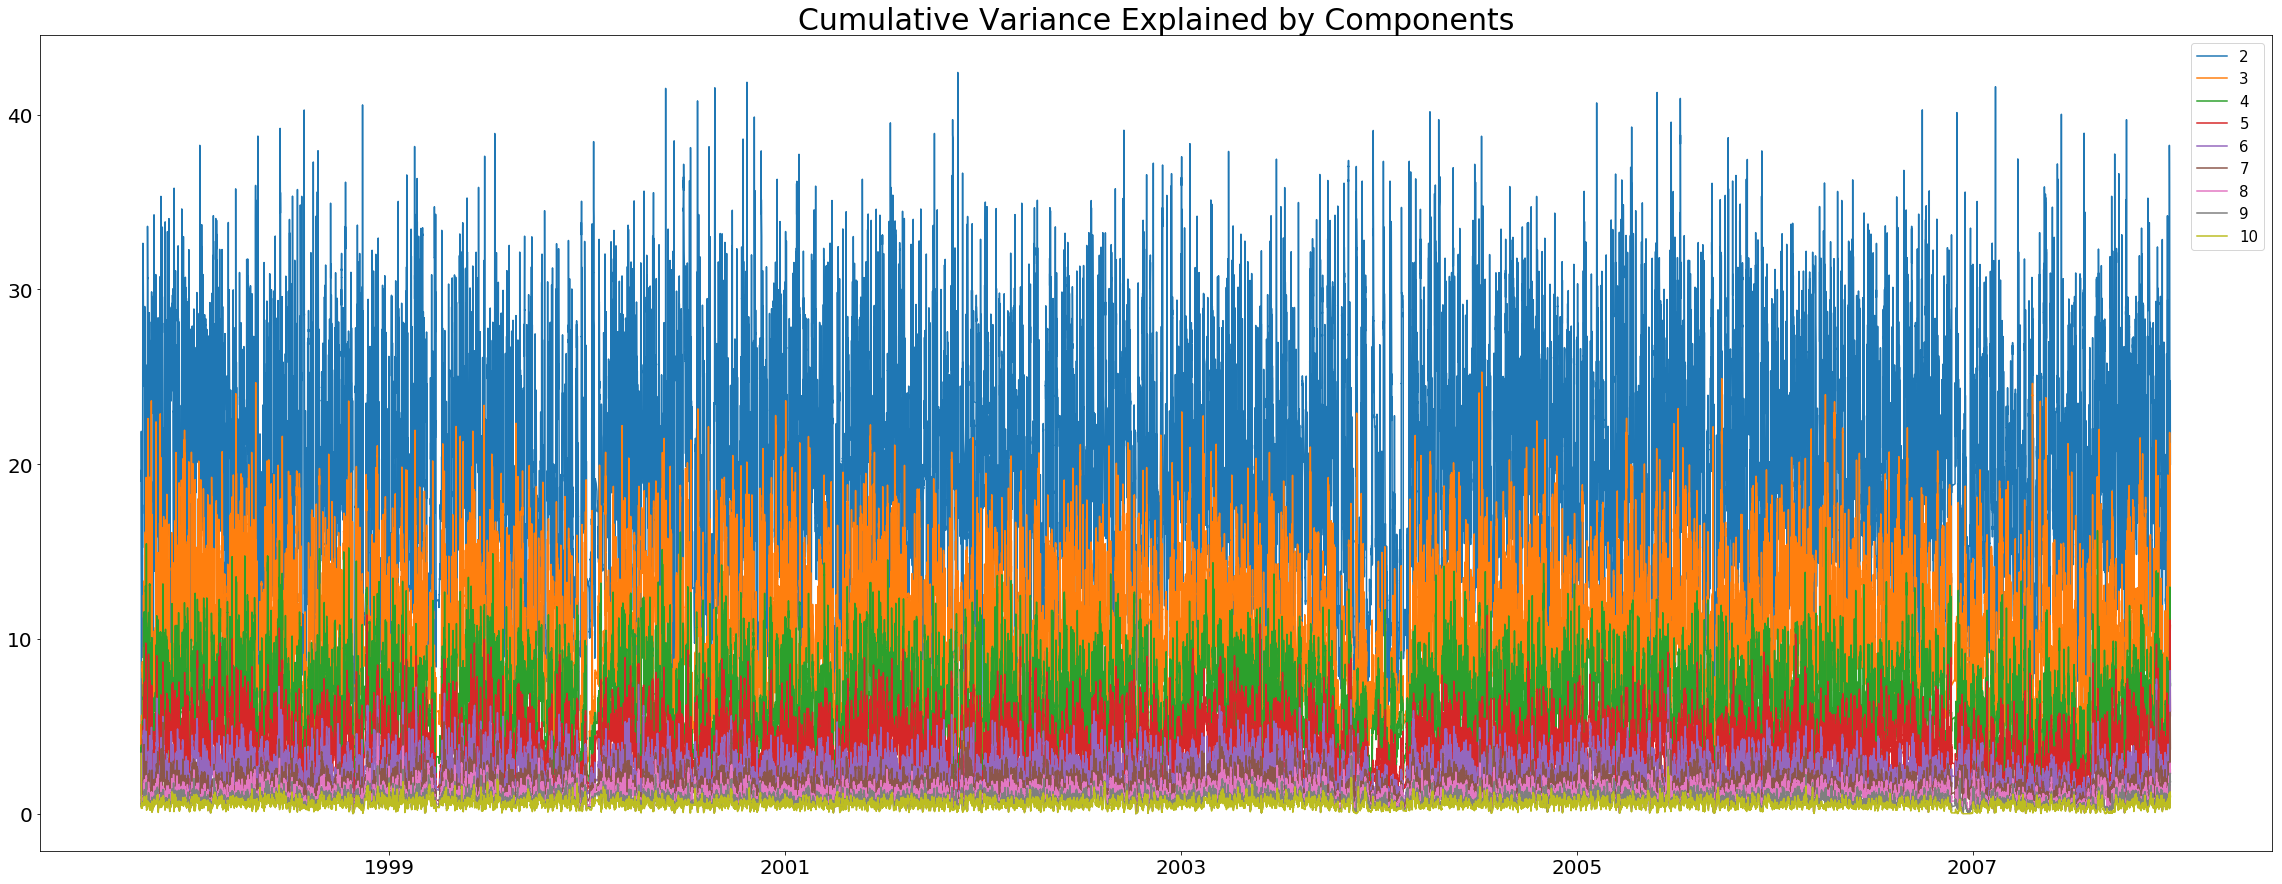

In [113]:
plt.figure(figsize=(40,15))
for i in range(1,10):
    plt.plot(data_train.index,eigs_frac[i,:].real,label = i + 1)
    plt.tick_params(labelsize=20)
    plt.title('Cumulative Variance Explained by Components', fontsize = 30)
    plt.legend(fontsize = 15)

$\mathbf{E_t}$ matrices modifies the underlying latent processes. Through observing the eigenvectors, we could have a deeper understanding about the correlation structures among each component. The heat map below shows the projection of $e_{t,j}$ for $j = 1,...,50$, and $t = 1,...,170$. As we can see from the heat map of component 1, we found that the topic 'extortion' and 'senate race' have different direction with all the other terms throughout the time. On the other hand, the topic 'cost of health care' dominates component 2 in the early time period. However, as time goes by, it was replaced by the topic 'hostage crisis' and 'civil rights act of 1964'. In component 3, the direction of the topic 'unique thrift' is opposite to the topic 'hostage crisis'. These figures could serve as a reference of dynamic clustering.


* Figure 6: Heat Map of $\mathbf{E_t}$ 

In [114]:
cluster_heatmap(model,1,50)
cluster_heatmap(model,2,50)
cluster_heatmap(model,3,50)
cluster_heatmap(model,4,50)

NameError: name 'Date' is not defined

* Figure 8: Scatter plot of the second and third component

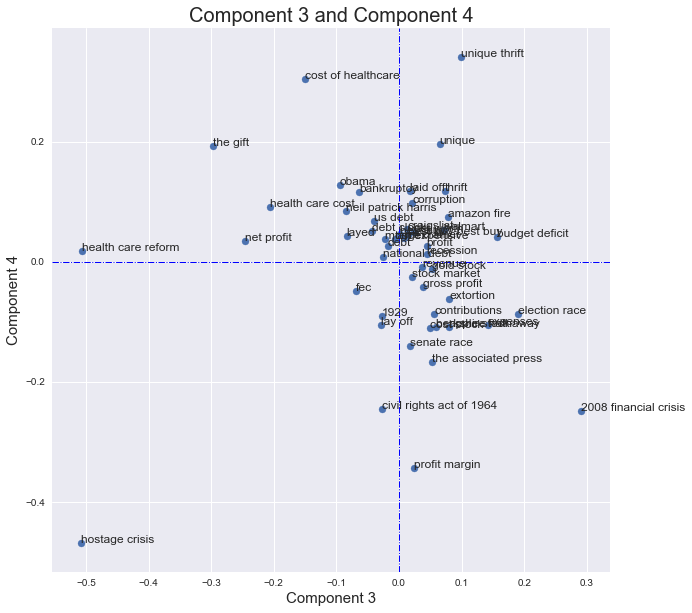

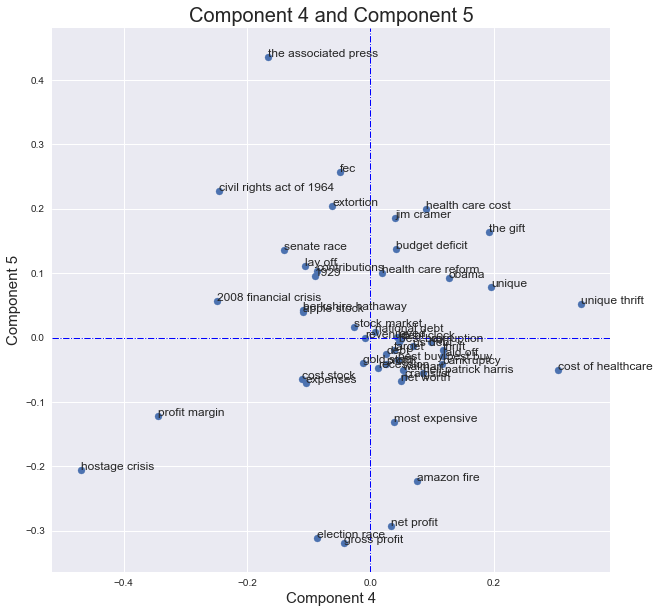

In [17]:
# Scatter plot for component 3 and component 4
scatter(model,3,4)
# Scatter plot for component 3 and component 4
scatter(model,4,5)

We can explore the associations between principle components and the original variables by observing the elements of eigenvectors. According to the scatter plot above, there are few interesting features. For example, the topic 'Obama', 'health care reform', 'health care cost' are strongly correlated with each other in the figure of component 4 and component5. Generally, the topic with common terms will be classified in same cluster, which is similar to the result of hierarchical clustering.


We then explore the series of these underlying components. Consider $\mathbf{x_t}  = (x_{1,q},...,x_{t,q})'$, the principal component decomposition implies that $\mathbf{z_t = E'_{t}y_t}$. The figure below shows the series for component 1 to component 6. We can then construct a multivariate dlm and compute the KL divergence overtime with these components.


* Figure 8: Component Series 

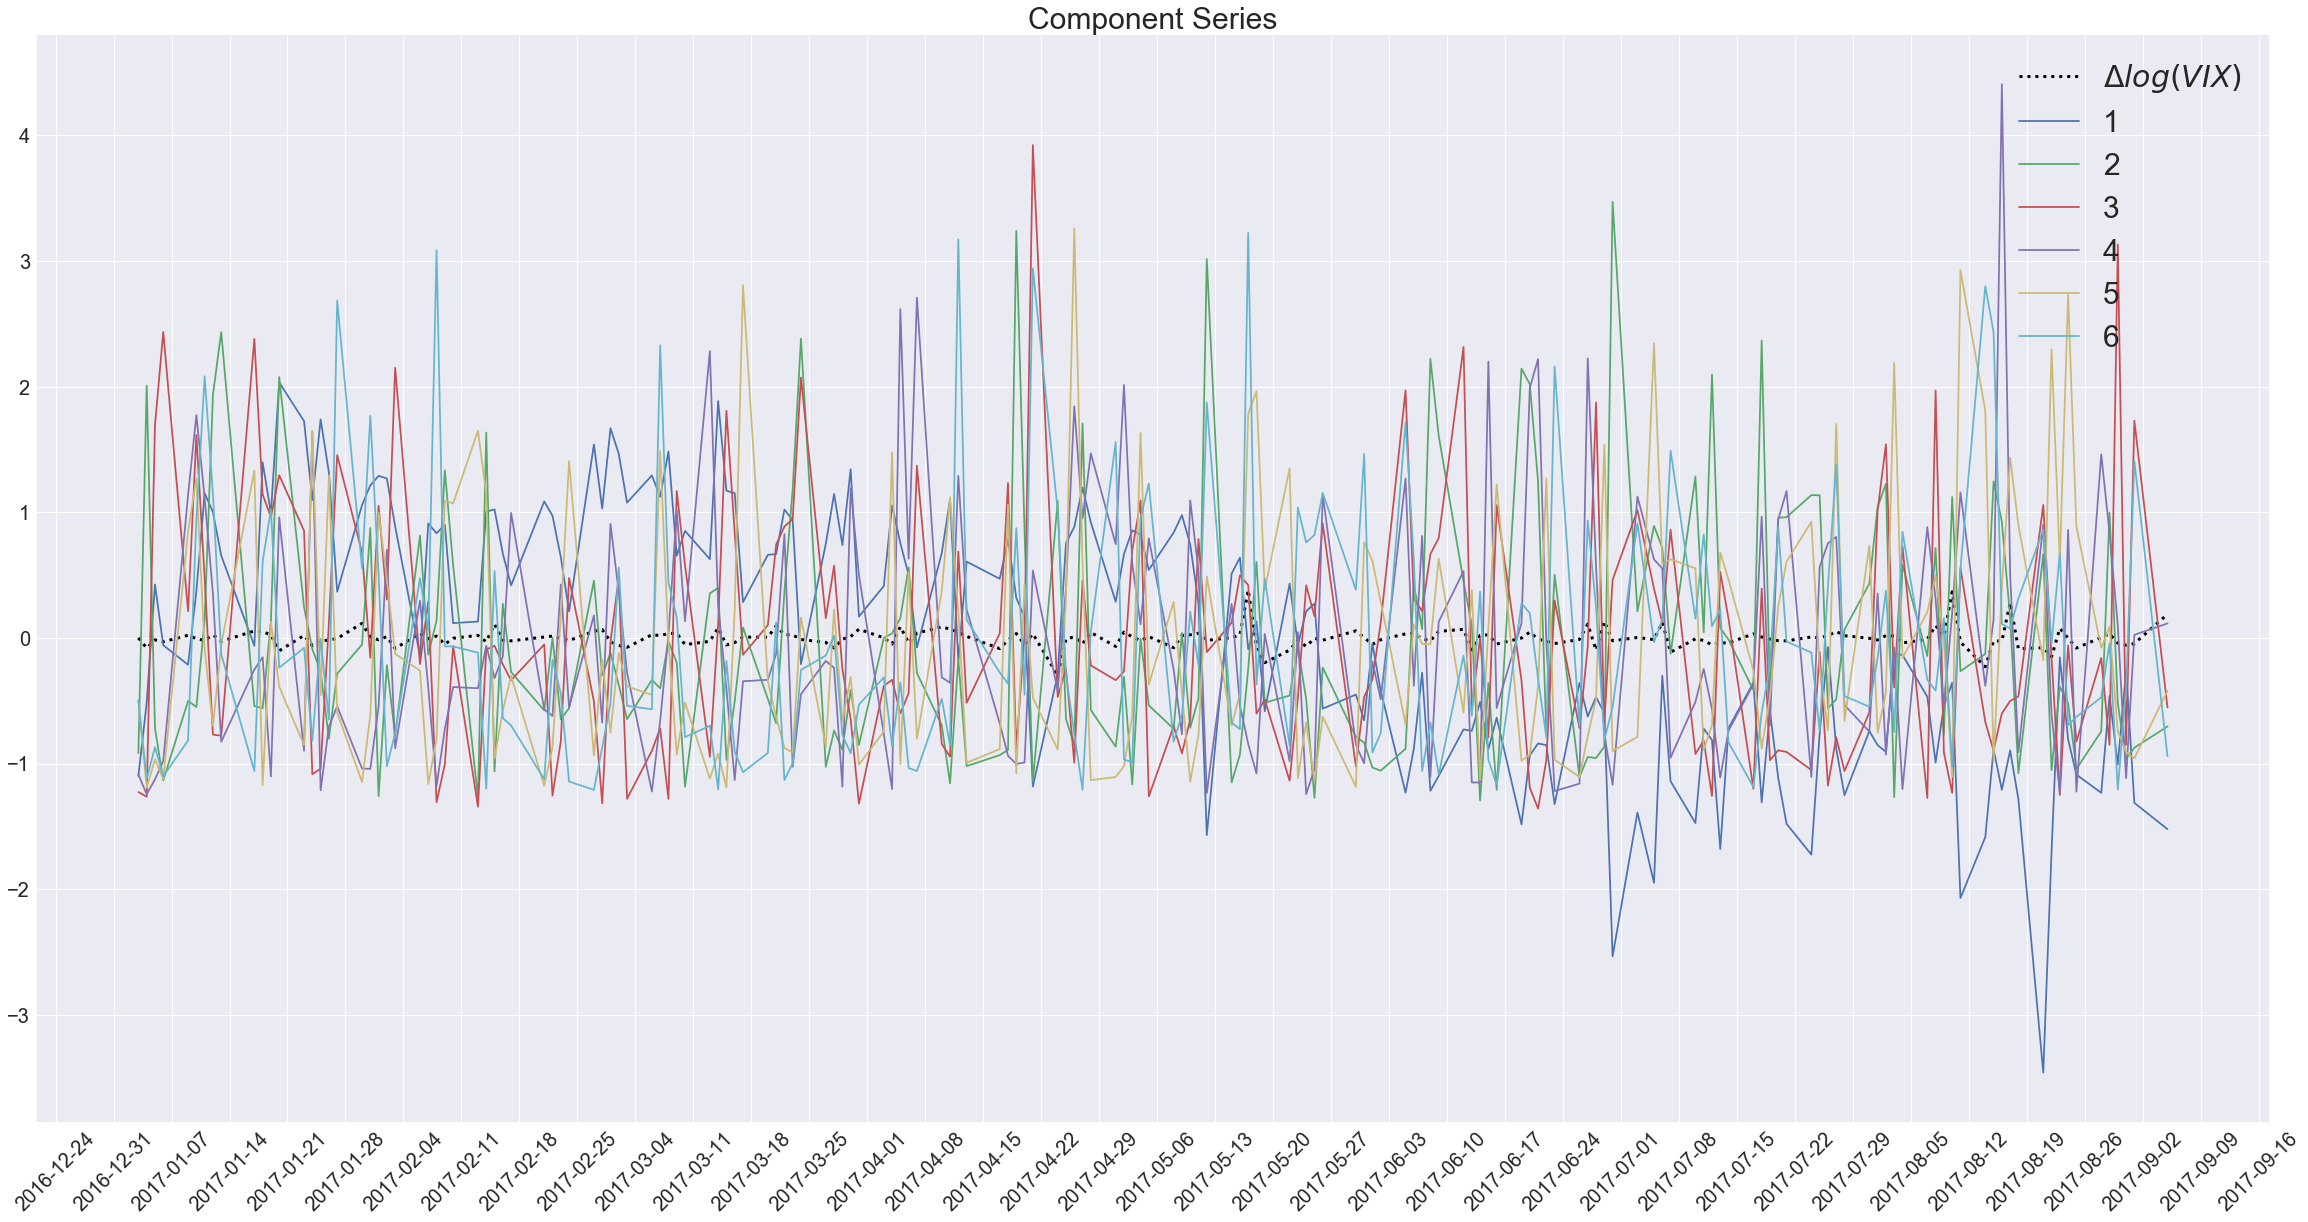

In [18]:
# First 6 components 
component = project_component(Y,eigs_vec,6)
component = component - np.mean(component,0)
component = component / np.std(component,0)

df_component = pd.DataFrame(component)
df_component.index = Date

# Plot 5 component series
plt.rc('xtick',labelsize=20)
plt.rc('ytick',labelsize=20)
fig, ax = plt.subplots(figsize=(40,20))
plt.setp(ax.get_xticklabels(), rotation=45)
plt.plot(np.array(Date),vix_close, label = r"$\Delta log(VIX)$", color = 'black',linestyle=':',linewidth=3)
for i in range(6):
    plt.plot_date(np.array(Date),
                  (df_component.iloc[:,i]),fmt='-',label = i+1);
ax.xaxis.set_major_locator(dates.DayLocator(interval = 7))
ax.xaxis.set_major_formatter(dates.DateFormatter('%Y-%m-%d'))
ax.set_title('Component Series',fontsize = 30);
ax.legend(fontsize = 30);


# Kullback–Leibler divergence of covariance distribution


The Kullback–Leibler (KL) divergence measures how one probability distribution diverges from another probability distribution. In this project, we are interested in applying KL divergence as a measure to monitor the impact of data on the covariance matrix $\mathbf{\Sigma_t}$. The goal is to suggest a purely observational interpretation of the KL divergences a measure of market volatility, with The Google Trend data. Thus, we will compare the result with the VIX index, which is a popular indicator of market volatility. 

Thus, we will app;y KL divergence to evaluate the difference between time $t$ posterior and time $t$ prior distribution of covariance matrix $\mathbf{\Sigma_t}$. 

###  DLM Sequential Update
Consider the multivariate DLM for a q-dimensional time series: $\mathbf{y_t \sim N(\Theta^{'}_t F_t, \Sigma_t)}$ (Prado and West 2010), the sequential updating could be summarized as:

* Time $t-1$ posterior : $$\mathbf{(\Theta_{t-1}, \Sigma_{t-1}|D_{t-1}) \sim NIW(M_{t-1},C_{t-1}, n_{t-1}, D_{t-1})}$$
, with degrees of freedom of Wishart $d_{t-1} = n_{t-1} + q - 1$, so $n_{t-1} = d_{t-1} - q + 1$.

* Time $t$ prior :
$$\mathbf{(\Theta_t,\Sigma_t|D_{t-1}) \sim NIW (G_t M_{t-1},\text{  } G_{t}C_{t-1}G_t^{'} + W_t,\text{  } \beta d_{t-1} - q + 1, \text{  } \beta D_{t-1})}$$, where $\beta$ is the discount factor. 

* Time t posterior: 
$$\mathbf{(\Theta_t,\Sigma_t|D_t) \sim NIW(M_t,C_t,n_t,D_t)}$$
, where $\mathbf{A_t} = \mathbf{R_tF_t}/\omega_t$, $\mathbf{e_t = y_t - H^{'}F_t}$, and $\omega_t = 1 + \mathbf{F^{'}_t R_t F_t}$

   + $\mathbf{M_t = H_t + A_t e_t^{'}}$ and $\mathbf{C_t = R_t - A_t A_t^{'}} \omega_t$.
   + $\mathbf{D_t = B_t + e_t e_t^{'}}/\omega_t$, $n_t = s_t + 1$ and $d_t = n_t + q - 1$.


### Inverse Wishart KL divergence

Suppose we have two inverse wishart distribution $p(\mathbf{\Sigma}): \Sigma \sim IW(s,\mathbf{B})$ and $g(\mathbf{\Sigma}): \Sigma \sim IW(n,\mathbf{D})$, where the degrees of freedom are $g = s+q -1$ and $d = n+ q -1$ respectively. The density function is:
$$p(\mathbf{\Sigma}) = c_{q,n} |\mathbf{D}|^{(n+q-1)/2}|\mathbf{\Sigma}|^{-(q+n/2)}etr\{\mathbf{-\Sigma^{-1}D}/2\}$$
, with $c^{-1}_{q,n} = 2^{dq/2}\Gamma_p (d/2)$


The KL divergence could be stated as: 
$$\begin{aligned} 
K_{g|p} &= \int _\mathbf{\Sigma_t} log \frac{p(\mathbf{\Sigma_t})}{g(\mathbf{\Sigma_t})}  p(\mathbf{\Sigma_t})\mathbf{ d\Sigma_t}\\
&= log(\frac{c_{q,s}}{c_{q,n}}) + glog(|\boldsymbol{B}|)/2 - dlog(|\boldsymbol{D}|)/2 + (d-g)E_p[log(|\boldsymbol{\Sigma}|)]/2 + g(tr\{B^{-1}D\}-q)/2
\end{aligned}$$
, where $E_p[log(|\boldsymbol{\Sigma}|)] = log(|\boldsymbol{B}|) - qlog(2) - \sum^{q}_{i = 1}\phi(\frac{s+q-i}{2})$ and $\phi(.)$ is the dgamma function.

### Data Analysis with KL Divergence

After deriving the formula above, we can use it to measure the change of covariance distribution on the time $t$ updating. In this case, we selected 6 components series and constructed a multivariate dynamic linear model with local mean to explore its covariance structure.  Thus, by observing the change of covariance distribution, we are able to monitor the subtle levels of stochastic variation over time, under the context of dominant variation. Besides exploring the change of overall 6 components series, we also measure the divergence on the subset of time series. Since $\mathbf{(\Theta, \Sigma) \sim NIW(M,C, n, D)}$ will imply $\mathbf{(\Theta}(:,i), \boldsymbol{\Sigma}(i,i)) \sim \boldsymbol{NIW}(\boldsymbol{M}(:,i),\boldsymbol{C}, n, \boldsymbol{D}(i,i))$. Thus, we will also focus on the KL divergence for the first 3 component series and the last 3 series, respectively. Notice that the scale of KL divergence depends on dimension and context. Thus, we might want to consider the "normalized" KL divergence. First, we divide the KL measure by the number of dimension. In addition, we consider $ESS = \frac{1}{1+KL}$ as discussed in (Gruber and West 2016), which using an absolute scale regarding importance sampling. The divergence is non-negative, and the larger the value is, the larger the difference between prior and posterior distribution. 


In [19]:
Y = transpose(np.mat(component))
q,T = Y.shape
Y = Y - np.mean(Y,1) 
# Normalized 

p=1;    
F = np.mat(np.ones([1,T]));    
# simple local mean model with volatility; p = r in notes 

delta=0.95;    # discount level
beta =0.95;    # discount volatility: original Matrix Beta-IW model

h0=1/(1-beta); 
n0=h0-q+1;      # h = d in notes
D0 = h0 * np.eye(q)
z = np.mat(np.zeros([p,q]))
zq = np.mat(np.zeros([q,1]))
M0=z; r=0.99; # priors
Mt = M0;
C0=.1*np.eye(p); 
Ct=C0;           # initial Theta prior 
nt = n0; ht=h0; Dt = D0; 
St=Dt/ht;         
sCt = np.zeros([p,p,T]); sDt = np.zeros([q,q,T]); 
snt = np.zeros([1,T]);
KL = np.zeros([2,T]); 



In [20]:
# KL for overall series
KLall = np.zeros([2,T])
# KL for subset 1~3
KLI = np.zeros([2,T])
# KL for subset 4~6
KLJ = np.zeros([2,T])
for t in range(T):
    ft = np.matrix(transpose(Mt) @ F[:,t])
    et = Y[:,t] - ft; Rt = Ct/delta; 
    ht  = beta*ht; nt = ht-q+1;
    Dt = beta*Dt;  
    qvt = 1 + transpose(F[:,t])@Rt@F[:,t]; 
    At = Rt@F[:,t]/qvt;
    # KL: 
    KLall[:,t] = KLdivNIWDLM( q,  p, et, F[:,t], Mt, 
                             Rt, nt, Dt, At, qvt );
    KLI[:,t]   = KLdivNIWDLM( 3, p, et[0:3], F[:,t], Mt[:,0:3], 
                             Rt, nt, Dt[0:3,0:3], At, qvt );
    KLJ[:,t]   = KLdivNIWDLM( 3, p, et[3:6], F[:,t], Mt[:,3:6], 
                             Rt, nt, Dt[3:6,3:6], At, qvt );
    # update:
    ht=ht+1;
    nt=nt+1;
    Dt += et @ transpose(et)/qvt
    St=Dt/ht; 
    St=(St+transpose(St))/2; 
    Mt = Mt + At@transpose(et);
    Ct = Rt - At@np.transpose(At)*qvt;
   

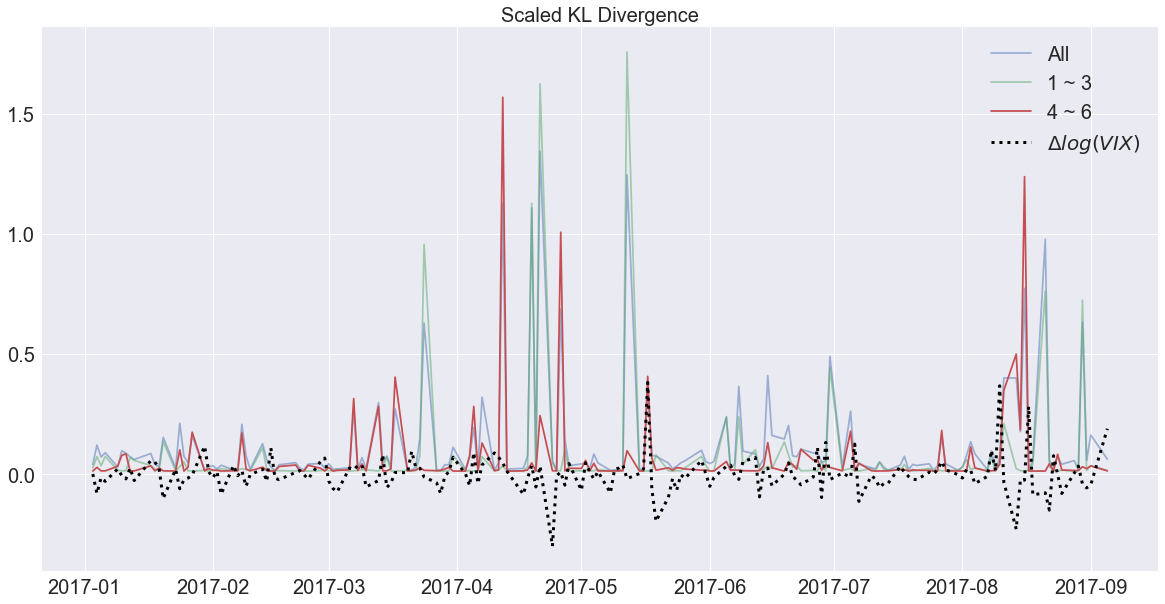

In [21]:
plt.figure(figsize=(20,10))
plt.plot(np.array(Date),transpose(KLall[1,:]/6),label = 'All',alpha = 0.5);
plt.plot(np.array(Date),transpose(KLI[1,:]/3), label = '1 ~ 3',alpha = 0.5);
plt.plot(np.array(Date),transpose(KLJ[1,:]/3), label = '4 ~ 6');
plt.plot(np.array(Date),vix_close, label = r"$\Delta log(VIX)$", 
         color = 'black',linestyle=':',linewidth=3)
plt.title('Scaled KL Divergence', fontsize = 20)
plt.legend(fontsize = 20);

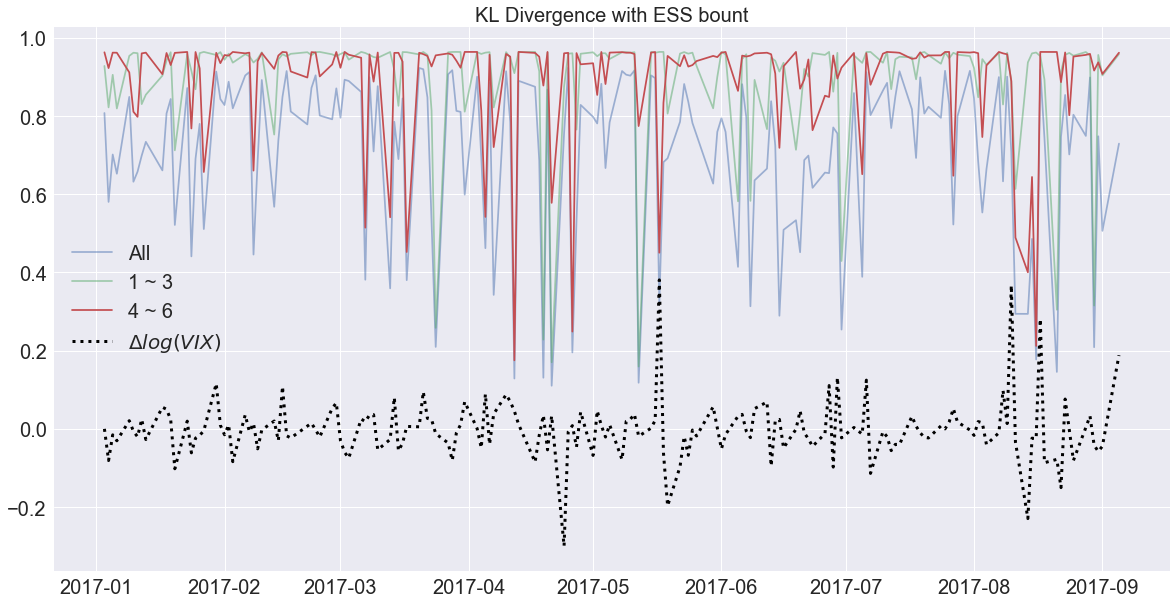

In [22]:
plt.figure(figsize=(20,10))
plt.plot(np.array(Date),transpose(1/(1 + KLall[1,:])),label = 'All',alpha = 0.5);
plt.plot(np.array(Date),transpose(1/(1 + KLI[1,:])), label = '1 ~ 3',alpha = 0.5);
plt.plot(np.array(Date),transpose(1/(1 + KLJ[1,:])), label = '4 ~ 6');
plt.plot(np.array(Date),vix_close, label = r"$\Delta log(VIX)$",
         color = 'black',linestyle=':',linewidth=3)

plt.title('KL Divergence with ESS bount', fontsize = 20)
plt.legend(fontsize = 20);

As we can see from the overlaid plots above, there is a strong concordance between KL divergence and VIX index in late period of our time frame. In particular, the subset of the component series (4th, 5th and 6th) successfully captures the market volatility as the VIX index does. Thus, it is reasonable to consider the KL divergence between the prior and posterior distribution of $\Sigma$, to be a potential market indicator.  

# Summary of the Analysis and Discussion

In this project, we analyze the search volume data from The Google Trend. The original dataset collects 148 series. We first use Pearson's correlation to explore the correlation between each series and the VIX index then select 50 series with highest correlation. Further, we use hierarchical clustering as an exploratory tool to explore the cluster structure. 

After the exploratory data analysis, we apply dynamic PCA on the dataset. There are several findings in this analysis. First, we could observe the cumulative variance explained by components, and find that the first component explained most of the variance overtime. Second, we looked at the entries of eigenvector and used it as the reference of clustering. As we can see from the heat map and scatter plot, we could observe the association and correlation structure between components and topics. Finally, we projected the series on new coordinate system, reducing the dimension from 148 to 6. 

Further, we used these component series to construct a new multivariate dlm and measure the KL divergence of the covariance distribution overtime. From the overlaid plot, we find the series of KL divergence is similar the VIX index, which suggest that the series of KL divergence, constructed from the component series, could potentially be a market volatility indicator.   

Although dynamic PCA serve as an useful tool to explore the correlation and clustering structure of time serie, there are some drawbacks of dynamic PCA. One most relevent disadvantage is that, even a slight change in covariance matrix might have great impact on the eigenstructure. Thus, a future work might be considering a modified version of PCA to stablize the eigenstructure during sequential updating. In addition, in current analysis, we manually select 6 as the final number of component. We might want to apply Sparse PCA to identify important variables in further analysis.


**Reference**
* Lecture Notes of STA 832 Multivariate Statistical Analysis

* Lecture Notes of STA 642 Time Series and Dynamic Models

* Notes of KL Divergence from Mike West and Wenli Shi

* Da, Zhi, Joseph Engelberg, and Pengjie Gao. "The sum of all FEARS investor sentiment and asset prices." The Review of Financial Studies 28, no. 1 (2014): 1-32.

* Prado, Raquel, and Mike West. Time series: modeling, computation, and inference. CRC Press, 2010.

* Gruber, Lutz F., and Mike West. "Bayesian forecasting and scalable multivariate volatility analysis using simultaneous graphical dynamic models." arXiv preprint arXiv:1606.08291 (2016).

